# Combining three data sources for visualisation

In [1]:
from WGS import WGS
from GMRF.GMRF import GMRF
from usr_func.normalize import normalize
from usr_func.checkfolder import checkfolder
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
from scipy.stats import norm
import numpy as np
import pandas as pd
import os
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from rasterio.plot import show, adjust_band
from shapely.geometry import Polygon, Point
from matplotlib.cm import get_cmap
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20


filepath = "csv/"

plg = pd.read_csv(filepath + "polygon.csv").to_numpy()
gmrf = GMRF()

GMRF threshold is loaded as:  27.8


In [2]:
os.listdir(filepath)

['cond',
 'samples',
 'AUVData.csv',
 'df_mohid.csv',
 'trajectory',
 'polygon.csv',
 'satellite.csv']

## Source I: MOHID

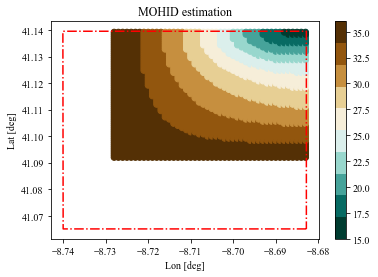

In [3]:
df_mohid = pd.read_csv(filepath + "df_mohid.csv").to_numpy()
plt.scatter(df_mohid[:, 1], df_mohid[:, 0], c=df_mohid[:, 2], cmap=get_cmap("BrBG_r", 10), vmin=15, vmax=36)
plt.plot(plg[:, 1], plg[:, 0], 'r-.')
plt.xlabel('Lon [deg]')
plt.ylabel('Lat [deg]')
plt.title('MOHID estimation')
plt.colorbar()

## Source II: Sentinel-2

In [50]:
df_satellite = pd.read_csv(filepath + "satellite.csv").to_numpy()
value = normalize(df_satellite[:, 2], 0, 10) ** 4

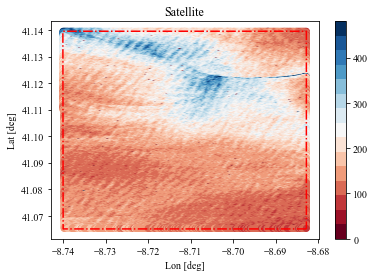

In [5]:
plt.scatter(df_satellite[:, 1], df_satellite[:, 0], c=value, cmap=get_cmap("RdBu", 15), vmin=.0, vmax=480)
plt.plot(plg[:, 1], plg[:, 0], 'r-.')
plt.xlabel('Lon [deg]')
plt.ylabel('Lat [deg]')
plt.title('Satellite')
plt.colorbar()

## Source III: AUV

In [6]:
def interpolate_grid(x, y, z) -> tuple:
    """
    This function only works for this specific case since the grid from spde is not rectangular for plotting purposes.
    """
    xmin, ymin, zmin = map(np.amin, [x, y, z])
    xmax, ymax, zmax = map(np.amax, [x, y, z])

    xn = np.linspace(xmin, xmax, 25)
    yn = np.linspace(ymin, ymax, 25)
    zn = np.linspace(zmin, zmax, 5)
    grid = []
    ind = []
    t1 = time.time()
    for i in range(xn.shape[0]):
        for j in range(yn.shape[0]):
            for k in range(zn.shape[0]):
                loc = [xn[i], yn[j], zn[k]]
                grid.append(loc)
                ind.append(gmrf.get_ind_from_location(np.array(loc)))
    t2 = time.time()
    print("Time for interpolation: ", t2 - t1)
    return np.array(grid), np.array(ind)

def interpolate_grid_wgs(x, y, z) -> tuple:
    """
    x and y here refers to lat, lon
    """
    xmin, ymin, zmin = map(np.amin, [x, y, z])
    xmax, ymax, zmax = map(np.amax, [x, y, z])

    xn = np.linspace(xmin, xmax, 25)
    yn = np.linspace(ymin, ymax, 25)
    zn = np.linspace(zmin, zmax, 5)
    grid = []
    ind = []
    t1 = time.time()
    for i in range(xn.shape[0]):
        for j in range(yn.shape[0]):
            for k in range(zn.shape[0]):
                xt, yt = WGS.latlon2xy(xn[i], yn[j])
                loc = [xt, yt, zn[k]]
                grid.append([xn[i], yn[j], zn[k]])
                ind.append(gmrf.get_ind_from_location(np.array(loc)))
    t2 = time.time()
    print("Time for interpolation: ", t2 - t1)
    return np.array(grid), np.array(ind)

In [7]:
files_mu = os.listdir(filepath + "cond/mu/")
files_mu.sort()

threshold = 31.0
def get_ep(mu, sigma_diag) -> np.ndarray:
    p = norm.cdf(threshold, mu, sigma_diag)
    return p

data = pd.read_csv(filepath + "cond/mu/d_00.csv").to_numpy()
gx = data[:, 0]
gy = data[:, 1]
gz = data[:, 2]
depths = np.unique(gz)
# la, lo = WGS.xy2latlon(gx, gy)

# ind_layer = np.where(gz == .5)[0]
# x = gx[ind_layer]
# y = gy[ind_layer]
# sal = np.zeros([len(ind_layer), len(depths)])

# for i in range(len(depths)):
#     ind_layer = np.where(gz == depths[i])[0]
#     sal[:, i] = data[ind_layer, -1]
# # d_traj = pd.read_csv(filepath + "trajectory/d_01.csv").to_numpy()
# # la, lo = WGS.xy2latlon(gx, gy)
# sal_total = data[:, -1]

glat, glon = WGS.xy2latlon(gx, gy)

# grid_plot, ind_plot = interpolate_grid(gx, gy, gz)
grid_plot, ind_plot = interpolate_grid_wgs(glat, glon, gz)
xplot = grid_plot[:, 1]
yplot = grid_plot[:, 0]
zplot = grid_plot[:, 2]


Time for interpolation:  3.874824047088623


In [8]:
figpath = "./../../fig/OP1_MAFIA/updated/"
checkfolder(figpath)
os.listdir(figpath)

[]

In [19]:
os.listdir(filepath + "trajectory/")

['d_07.csv',
 'd_13.csv',
 'd_12.csv',
 'd_06.csv',
 'd_10.csv',
 'd_04.csv',
 'd_05.csv',
 'd_11.csv',
 'd_15.csv',
 'd_01.csv',
 'd_14.csv',
 'd_02.csv',
 'd_16.csv',
 'd_17.csv',
 'd_03.csv',
 'd_08.csv',
 'd_09.csv']

In [27]:
def plot_figure(value, trajectory=np.empty([0, 3]), vmin=0, vmax=30, filename=None, title=None, cmap=None):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]])
    
    """Scatter3d""" 
#     fig.add_trace(go.Scatter3d(
#         x=xplot,
#         y=yplot,
#         z=zplot,
#         mode="markers",
#         marker=dict(
#             size=10,
#             cmin=vmin,
#             cmax=vmax,
#             opacity=.3,
#             color=value,
#             colorscale=cmap,
#             showscale=True,
#             colorbar=dict(x=0.75, y=0.5, len=.5),
#         )))

    """Volume""" 
#     fig.add_trace(go.Volume(
#         x=xplot,
#         y=yplot,
#         z=zplot,
#         value=value,
#         isomin=vmin,
#         isomax=vmax,
#         opacity=.3,
#         surface_count=15,
#         colorscale=cmap,
#         # coloraxis="coloraxis",
#         colorbar=dict(x=0.75, y=0.5, len=.5),
#         # reversescale=True,
#         caps=dict(x_show=False, y_show=False, z_show=False),
#     ))

    """Isosurface"""
    for i in range(len(np.unique(zplot))):
        ind = (zplot == np.unique(zplot)[i])
        fig.add_trace(
            go.Isosurface(x=xplot[ind], y=yplot[ind], z=zplot[ind], value=value[ind], isomin=vmin, isomax=vmax, coloraxis='coloraxis'),
            row=1, col=1
        )
    fig.update_coloraxes(colorscale=cmap,
                         colorbar=dict(x=0.75, y=0.5, len=.5),)
    
    if len(trajectory) > 0:
        
        wp = trajectory
        lat, lon = WGS.xy2latlon(wp[:, 0], wp[:, 1])
        zt = trajectory[:, 2]
        for k in range(len(depths)):
            dmin = depths[k] - .5
            dmax = depths[k] + .5
            ind = np.where((traj >= dmin) * (traj < dmax))[0]
            zt[ind] = depths[k]
        
        fig.add_trace(go.Scatter3d(
            name="Trajectory",
            x=lon,
            y=lat,
            z=zt,
            mode='markers+lines',
            marker=dict(
                size=5,
                color="black",
                showscale=False,
            ),
            line=dict(
                color="yellow",
                width=3,
                showscale=False,
            ),
            showlegend=True,
        ),
            row='all', col='all'
        )

    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.5, y=2., z=1.7)  
    )
    fig.update_layout(
        title={
#             'text': "Conditional " + title + " field",
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        scene=dict(
            zaxis=dict(nticks=5, range=[-4.52, -.49], ),
            xaxis_tickfont=dict(size=14, family="Times New Roman"),
            yaxis_tickfont=dict(size=14, family="Times New Roman"),
            zaxis_tickfont=dict(size=14, family="Times New Roman"),
            xaxis_title=dict(text="Lon [deg]", font=dict(size=18, family="Times New Roman")),
            yaxis_title=dict(text="Lat [deg]", font=dict(size=18, family="Times New Roman")),
            zaxis_title=dict(text="Depth", font=dict(size=18, family="Times New Roman")),
        ),
        scene_aspectmode='manual',
        scene_aspectratio=dict(x=1, y=1, z=1.5),
        scene_camera=camera,
    )
#     fig.write_image(filename, format='png', width=1980, height=1080)
    fig.show()

checkfolder(figpath + "mu/")   
checkfolder(figpath + "mvar/")   
checkfolder(figpath + "ep/")   

for i in range(len(files_mu)):
    print(i)
    mu = pd.read_csv(filepath + "cond/mu/" + files_mu[i]).to_numpy()[:, -1]
    mvar = pd.read_csv(filepath + "cond/mvar/" + files_mu[i]).to_numpy()[:, -1]
    ep = get_ep(mu, mvar)
    if i > 0:
        traj = pd.read_csv(filepath + "trajectory/" + files_mu[i]).to_numpy()
        
        plot_figure(mu[ind_plot], traj, vmin=15, vmax=36, cmap="BrBG", filename=figpath + "mu/P_{:02d}.png".format(i))
        plot_figure(mvar[ind_plot], traj, vmin=.0, vmax=.3, cmap="RdBu", filename=figpath + "mvar/P_{:02d}.png".format(i))
        plot_figure(ep[ind_plot], traj, vmin=.0, vmax=1., cmap="GnBu", filename=figpath + "ep/P_{:02d}.png".format(i))
    else:
        plot_figure(mu[ind_plot], vmin=15, vmax=36, cmap="BrBG", filename=figpath + "mu/P_{:02d}.png".format(i))
        plot_figure(mvar[ind_plot], vmin=.0, vmax=.3, cmap="RdBu", filename=figpath + "mvar/P_{:02d}.png".format(i))
        plot_figure(ep[ind_plot], vmin=.0, vmax=1., cmap="GnBu", filename=figpath + "ep/P_{:02d}.png".format(i))
    
#     if i > 3: 
    break

# plot_figure(mvar[ind_plot], traj, vmin=.0, vmax=.2, cmap="RdBu")
# plot_figure(ep[ind_plot], traj, vmin=.0, vmax=1., cmap="GnBu")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


## Sources combination


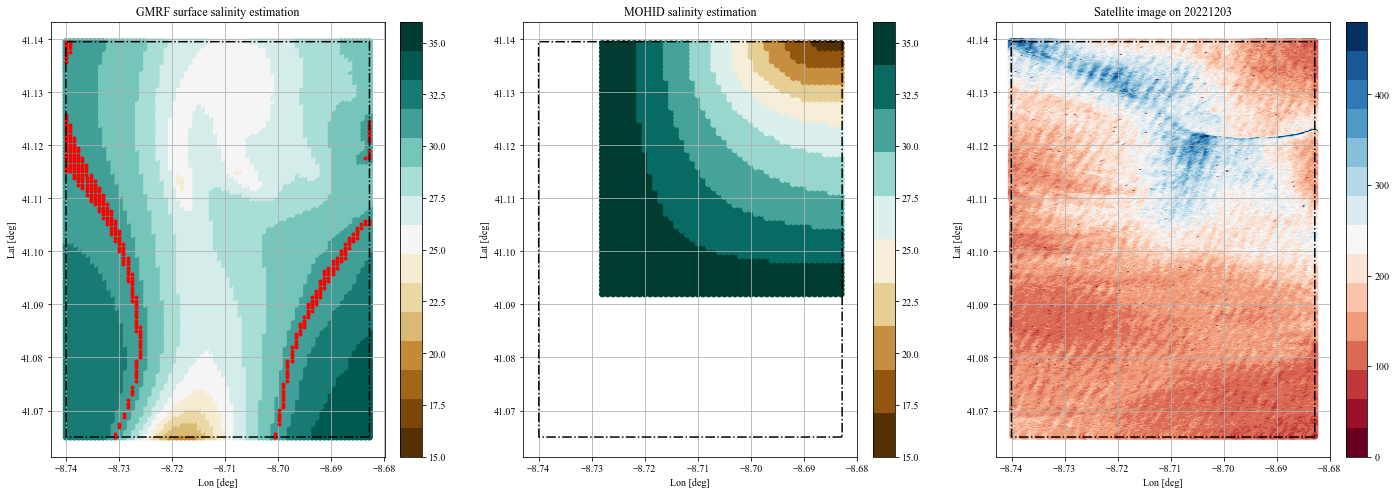

In [64]:
fig = plt.figure(figsize=(24, 8))
gs = GridSpec(nrows=1, ncols=3)
ax = fig.add_subplot(gs[0])
ind_surface = np.where(gz == -.5)[0]
sal = mu[ind_surface]
ind_threshold = np.where((sal >= threshold-.15) * (sal <= threshold+.15))[0]
im = ax.scatter(glon[ind_surface], glat[ind_surface], c=sal, cmap=get_cmap("BrBG", 15), vmin=15, vmax=36)
plt.colorbar(im, fraction=0.06, pad=0.04)
ax.plot(glon[ind_surface][ind_threshold], glat[ind_surface][ind_threshold], 'r.')
ax.plot(plg[:, 1], plg[:, 0], 'k-.')
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')
ax.set_title('GMRF surface salinity estimation')
ax.set_aspect("equal")
plt.grid()

ax = fig.add_subplot(gs[1])
im = ax.scatter(df_mohid[:, 1], df_mohid[:, 0], c=df_mohid[:, 2], cmap=get_cmap("BrBG", 10), vmin=15, vmax=36)
plt.colorbar(im, fraction=0.06, pad=0.04)
ax.plot(plg[:, 1], plg[:, 0], 'k-.')
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')
ax.set_title('MOHID salinity estimation')
ax.set_aspect("equal")
plt.grid()

ax = fig.add_subplot(gs[2])
im = ax.scatter(df_satellite[:, 1], df_satellite[:, 0], c=value, cmap=get_cmap("RdBu", 15), vmin=.0, vmax=480)
plt.colorbar(im, fraction=0.06, pad=0.04)
ax.plot(plg[:, 1], plg[:, 0], 'k-.')
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')
ax.set_title('Satellite image on 20221203')
ax.set_aspect("equal")
plt.grid()

plt.savefig(figpath + "../MAFIA_comparison.pdf", dpi=300)

In [62]:
figpath

'./../../fig/OP1_MAFIA/updated/'